# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import crispr as cr 
from crispr.crispr_class import Crispr
import pertpy as pt
import pandas as pd
import numpy as np
from config import (files_data, col_cell_type_data, col_gene_symbols_data, 
                    assays_data, layer_perturbation_data,
                    col_perturbation_data, key_control_data, 
                    col_split_by_data, layer_perturbation_data,
                    col_target_genes_data, key_nonperturbed_data,
                    key_treatment_data, col_guide_rna_data, col_batch_data,
                    col_sample_id_data, kws_process_guide_rna_data)

# Options
pd.options.display.max_columns = 100
skip_preprocessing_clustering = False  # to skip these steps
print(dir(cr.ax))
file = "CRISPRi_scr"
# file = "CRISPRi_ess"
# file = "ECCITE"
# file = "augur_ex"
# file = "coda"
# file = "screen"
# file = "perturb-seq"
kws_pca = dict(n_comps=None, use_highly_variable=True)
kws_neighbors = None  # passed to neighbors function
kws_umap = dict(min_dist=0.3)  # passed to UMAP fx
kws_cluster = dict(resolution=0.5)  # passed to louvain/leiden fx

#  Set Arguments
if file in assays_data:
    if isinstance(assays_data[file], str) or assays_data[file] is None:
        assays_data[file] = [assays_data[file], None]
    assay, assay_protein = assays_data[file]
else:
    assay, assay_protein = None
file_path = files_data[file]
kws_process_guide_rna = kws_process_guide_rna_data[file]
col_split_by = col_split_by_data[file]
kwargs_init = dict(assay=assay, assay_protein=assay_protein,
                   col_gene_symbols=col_gene_symbols_data[file],  
                   col_cell_type=col_cell_type_data[file], 
                   col_sample_id=col_sample_id_data[file], 
                   col_batch=col_batch_data[file],
                   col_perturbation=col_perturbation_data[file], 
                   col_guide_rna=col_guide_rna_data[file], 
                   col_target_genes=col_target_genes_data[file], 
                   layer_perturbation=layer_perturbation_data[file],
                   key_nonperturbed=key_nonperturbed_data[file],
                   key_control=key_control_data[file], 
                   key_treatment=key_treatment_data[file])
print(files_data)
if file == "default_fast":
    skip_preprocessing_clustering = True

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'analyze_composition', 'cluster', 'clustering', 'compute_distance', 'find_markers', 'perform_augur', 'perform_differential_prioritization', 'perform_gsea', 'perform_mixscape', 'perturbations']
{'CRISPRi_scr': {'directory': '/home/asline01/projects/crispr/examples/data/crispr-screening/HH03'}, 'CRISPRi_wgs': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_gwps.h5ad', 'CRISPRi_ess': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_esss.h5ad', 'pool': '/home/asline01/projects/crispr/examples/data/norman_2019_raw.h5ad', 'bulk': '/home/asline01/projects/crispr/examples/data/burczynski_crohn.h5ad', 'screen': '/home/asline01/projects/crispr/examples/data/dixit_2016_raw.h5ad', 'perturb-seq': '/home/asline01/projects/crispr/examples/data/adamson_2016_upr_perturb_seq.h5ad', 'ECCITE': '/home/asline01/projects/crispr/examples/data/papalexi_2021.h5a

# Setup Object

## Instantiate


This is more code than an end-user will actually need. `self = Crispr(file_path)` is the bare minimum needed (though you must specify some column and entry label names, such as the column name for the gene symbols, if they aren't the same as the defaults).

End users can simply pass to the `file` argument of `Crispr()` a 10x CellRanger output directory (or a dictionary of appropriate protospacer-related arguments if perturbation-related data aren't included in the .mtx file; see the `Crispr.preprocessing.combine_matrix_protospacer()` function for details) or .h5ad file if desired.

The extra code is just for generalizability across example datasets because in certain cases, we want to pass an AnnData Scanpy object because there are specific manipulations made to certain public datasets in the config.load_example_data function meant to decrease computation time/memory usage, etc.


In [2]:
# Initialize Object
print(f"Initialization arguments (from config):\n\n{kwargs_init}")
if isinstance(file, str) and file in ["ECCITE", "Adamson"]:
    self = Crispr(
        pt.data.papalexi_2021() if file == "ECCITE" else
        pt.data.adamson_2016_upr_perturb_seq(), **kwargs_init)
else:
    self = Crispr(file_path, **kwargs_init)
        
# Print
self.adata[self._assay].obs if self._assay else self.adata.obs

Initialization arguments (from config):

{'assay': None, 'assay_protein': None, 'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'name', 'col_guide_rna': 'feature_call', 'col_target_genes': 'target_gene_name', 'layer_perturbation': nan, 'key_nonperturbed': 'NP', 'key_control': 'NT', 'key_treatment': 'KD'}


 AnnData object with n_obs × n_vars = 15078 × 36601
    obs: 'num_features', 'feature_call', 'num_umis'
    var: 'gene_ids', 'feature_types'


{'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'name', 'col_guide_rna': 'feature_call', 'col_target_genes': 'target_gene_name'}

{'key_control': 'NT', 'key_treatment': 'KD', 'key_nonperturbed': 'NP'}




 AnnData object with n_obs × n_vars = 15078 × 36601
    obs: 'num_features', 'feature_call', 'num_umis'
    var: 'gene_ids', 'feature_types'


,num_features,feature_call,num_umis
AAACCCAAGAATTTGG-1,6.0,RASGRP1-1|PAF1-1|NEG_CTRL-2-1|NRBP1-2|RASGRP1-...,10|19|55|4|9|18
AAACCCAAGATTTGCC-1,2.0,SNX17-1|SNX17-2,200|33
AAACCCAAGCGATTCT-1,3.0,SP110-1|HLA-B-1|SP140L-2,12|22|7
AAACCCAAGTCGGGAT-1,NaN,NaN,NaN
AAACCCAAGTCTGCAT-1,6.0,RSBN1-1|PRDX6-1|STK11-1|RSBN1-2|PRDX6-2|NR4A1-2,194|381|51|513|119|47
...,...,...,...
TTTGTTGGTTGCCGAC-1,4.0,DUSP1-1|PPARA-1|TAGAP-2|DUSP1-2,48|19|4|46
TTTGTTGTCACTGTTT-1,2.0,ATG16L1-1|GPX4-1,73|125
TTTGTTGTCAGACCCG-1,NaN,NaN,NaN
TTTGTTGTCAGTGTGT-1,5.0,HLA-B-1|TMEM50B-1|DUSP1-1|DUSP1-2|RUNX3-P2-2,188|168|35|9|47


## Preprocess and Cluster

See `self.figures[run_label]["clustering"]` (object attribute) or method output for figures.

You must set use_highly_variable to False if you don't want to filter by HVGs
and if you did not set kws_hvg to None or False in `.preprocess()`


In that scenario, the 'highly_variable' column in  will be created in `.obsm` 
during `.preprocess()` and then used by default in `.cluster`.

UMAP Keywords: {'min_dist': 0.3}

<<< PROCESSING GUIDE RNAs >>>



<<< GUIDE RNAs PROCESSED: >>>


                    num_features feature_call_original num_umis KD_RASGRP1  \
AAACCCAAGATTTGCC-1           2.0       SNX17-1|SNX17-2   200|33         NT   
AAACCCAGTCTCAAGT-1           1.0                SPI1-2       11         NT   
AAACCCATCTCTCTTC-1           2.0     POLR2E-1|POLR2E-2  549|128         NT   
AAACGAACAACTCCAA-1           1.0          NEG_CTRL-5-2       47         NT   
AAACGAAGTTGAAGTA-1           2.0       SP100-1|SP100-2   164|31         NT   

                   KD_PAF1 KD_NT KD_NRBP1 KD_SNX17 KD_SP110 KD_HLA KD_SP140L  \
AAACCCAAGATTTGCC-1      NT    NT       NT       KD       NT     NT        NT   
AAACCCAGTCTCAAGT-1      NT    NT       NT       NT       NT     NT        NT   
AAACCCATCTCTCTTC-1      NT    NT       NT       NT       NT     NT        NT   
AAACGAACAACTCCAA-1      NT    KD       NT       NT       NT     NT        NT   
AAACGAAGTTGAAGTA-1      NT    NT

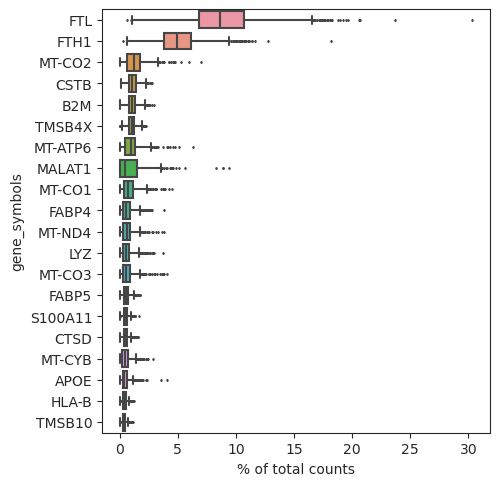


<<< FILTERING >>>

<<< DETECTING MITOCHONDRIAL GENES >>>

<<< PERFORMING QUALITY CONTROL >>>


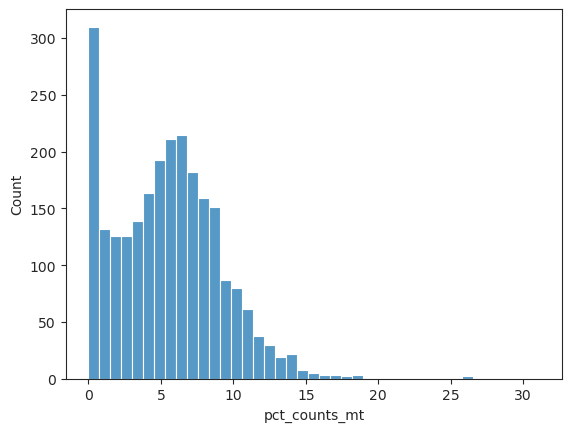

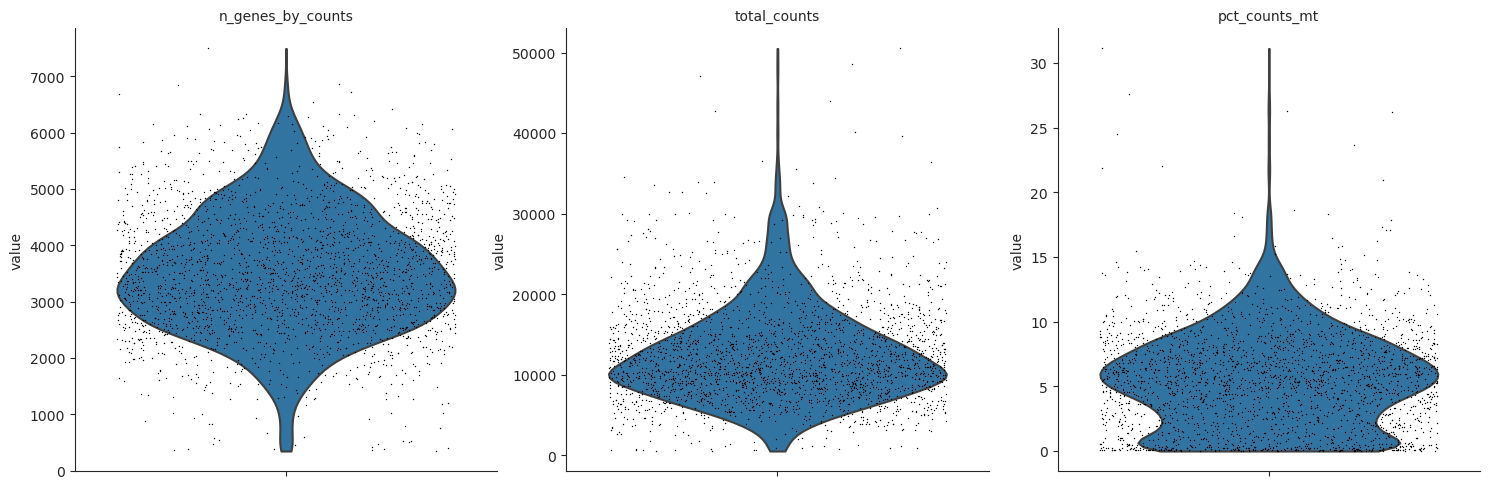

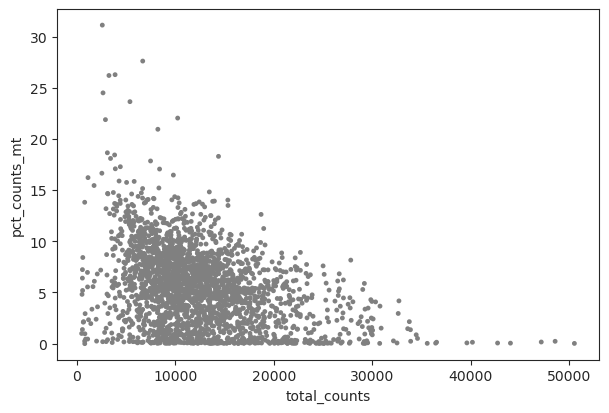

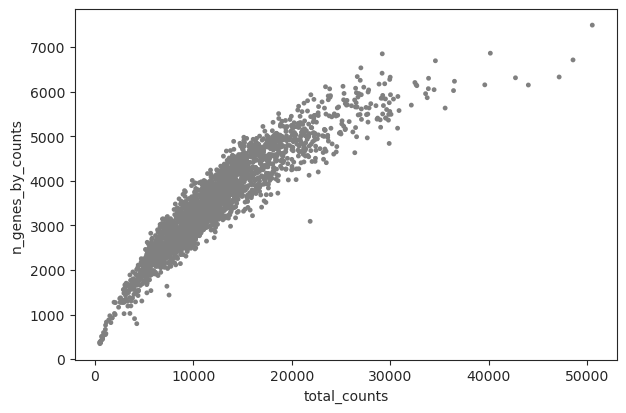


<<< NORMALIZING >>>

<<< DETECTING VARIABLE GENES >>>

<<< SCALING >>>



Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'col_perturbation': 'name', 'col_guide_rna': 'feature_call', 'col_target_genes': 'target_gene_name', 'key_control': 'NT', 'key_treatment': 'KD', 'key_nonperturbed': 'NP'}


<<< PERFORMING PCA >>>

 {'n_comps': None, 'use_highly_variable': True}


<<< COMPUTING NEIGHBORHOOD GRAPH >>>


<<< EMBEDDING: UMAP >>>

 {'min_dist': 0.3}


<<< CLUSTERING WITH LEIDEN METHOD >>>


<<< CREATING UMAP PLOTS >>>


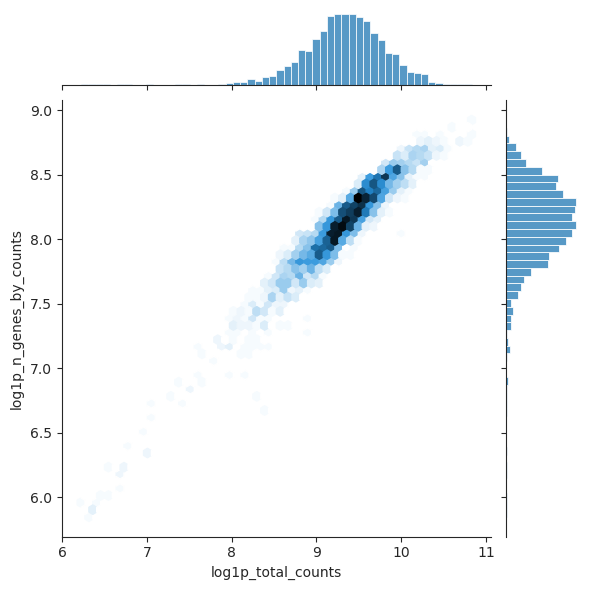

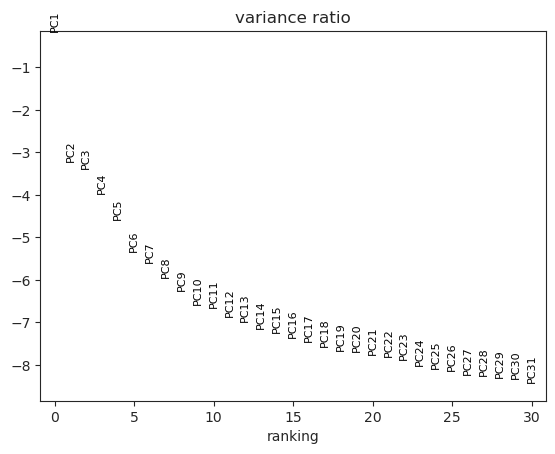

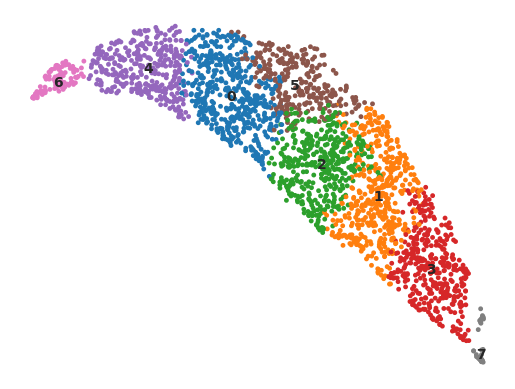

,num_features,feature_call_original,num_umis,KD_RASGRP1,KD_PAF1,KD_NT,KD_NRBP1,KD_SNX17,KD_SP110,KD_HLA,KD_SP140L,KD_NP,KD_RSBN1,KD_PRDX6,KD_STK11,KD_NR4A1,KD_WSB1,KD_PDPN,KD_IFNGR2,KD_TAGAP,KD_CRYZL1,KD_MYD88,KD_SPI1,KD_IFNAR2,KD_IL10RB,KD_PTPN22,KD_INPP5D,KD_DUSP1,KD_RUNX3,KD_TMEM50B,KD_LGALS9,KD_KSR1,KD_POLR2E,KD_IL6ST,KD_HIPK1,KD_PPARA,KD_GPX4,KD_NOD2,KD_CEBPB,KD_ABCA7,KD_LACC1,KD_MAFB,KD_ZFP36,KD_SP100,KD_CSF1R,KD_IRF8,KD_RIPK2,KD_SNX20,KD_ATG16L1,KD_RPN1,KD_PPM1G,KD_CYLD,KD_FASLG,KD_SPHK2,KD_RPN2,KD_PHTF1,KD_SBNO2,transfection,name,target_gene_name,target_gene_name_list,feature_call,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,leiden
AAACCCAAGATTTGCC-1,2.0,SNX17-1|SNX17-2,200|33,NT,NT,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,single,KD,SNX17,"[SNX17, SNX17]",SNX17-1_2,4762,4760,8.468213,17573.0,9.774176,1045.0,6.952729,5.946623,0
AAACCCAGTCTCAAGT-1,1.0,SPI1-2,11,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,single,KD,SPI1,[SPI1],SPI1-2,3272,3270,8.092851,10415.0,9.251099,1022.0,6.930495,9.812770,1
AAACCCATCTCTCTTC-1,2.0,POLR2E-1|POLR2E-2,549|128,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,single,KD,POLR2E,"[POLR2E, POLR2E]",POLR2E-1_2,3178,3174,8.063063,10591.0,9.267855,251.0,5.529429,2.369937,0
AAACGAACAACTCCAA-1,1.0,NEG_CTRL-5-2,47,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,single,NT,NT,[NT],NT-5-2,4248,4242,8.353026,15189.0,9.628392,932.0,6.838405,6.136020,0
AAACGAAGTTGAAGTA-1,2.0,SP100-1|SP100-2,164|31,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,single,KD,SP100,"[SP100, SP100]",SP100-1_2,4586,4585,8.430763,18979.0,9.851141,468.0,6.150603,2.465883,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGAGAGTTGGGAC-1,2.0,LGALS9-1|LGALS9-2,251|38,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,single,KD,LGALS9,"[LGALS9, LGALS9]",LGALS9-1_2,2664,2664,7.887959,9997.0,9.210140,566.0,6.340359,5.661698,0
TTTGGAGTCCGCTAGG-1,1.0,NEG_CTRL-2-2,32,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,single,NT,NT,[NT],NT-2-2,3773,3771,8.235361,12885.0,9.463897,1143.0,7.042286,8.870780,2
TTTGGAGTCCGGTTCT-1,2.0,TMEM50B-1|NEG_CTRL-1-1,34|62,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,single,KD,TMEM50B,"[TMEM50B, NT]",TMEM50B-1|NT-1-1,4531,4527,8.418036,14832.0,9.604609,873.0,6.773080,5.885922,0
TTTGGTTGTCTTGAGT-1,2.0,SPI1-1|SPI1-2,27|82,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,KD,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,NT,single,KD,SPI1,"[SPI1, SPI1]",SPI1-1_2,4694,4692,8.453827,16859.0,9.732699,97.0,4.584968,0.575360,0


In [3]:
if skip_preprocessing_clustering is False:  # if not already processed & clustered
    
    # Arguments
    print(f"UMAP Keywords: {kws_umap}")
    # Preprocess
    process_kws = dict(kws_hvg=dict(min_mean=0.0125, max_mean=3, min_disp=0.5),
                       target_sum=1e4, max_genes_by_counts=2500, max_pct_mt=15,
                       min_genes=200, min_cells=3, scale=10, regress_out=None,
                       kws_process_guide_rna=kws_process_guide_rna)
    self.preprocess(**process_kws, kws_umap=kws_umap)  # preprocessing
    
    # Cluster 
    self.cluster(method_cluster="leiden", kws_neighbors=kws_neighbors,
                 kws_pca=kws_pca, kws_umap=kws_umap,  kws_cluster=kws_cluster)
    
self.adata.obs

### Find Markers (DEGs)

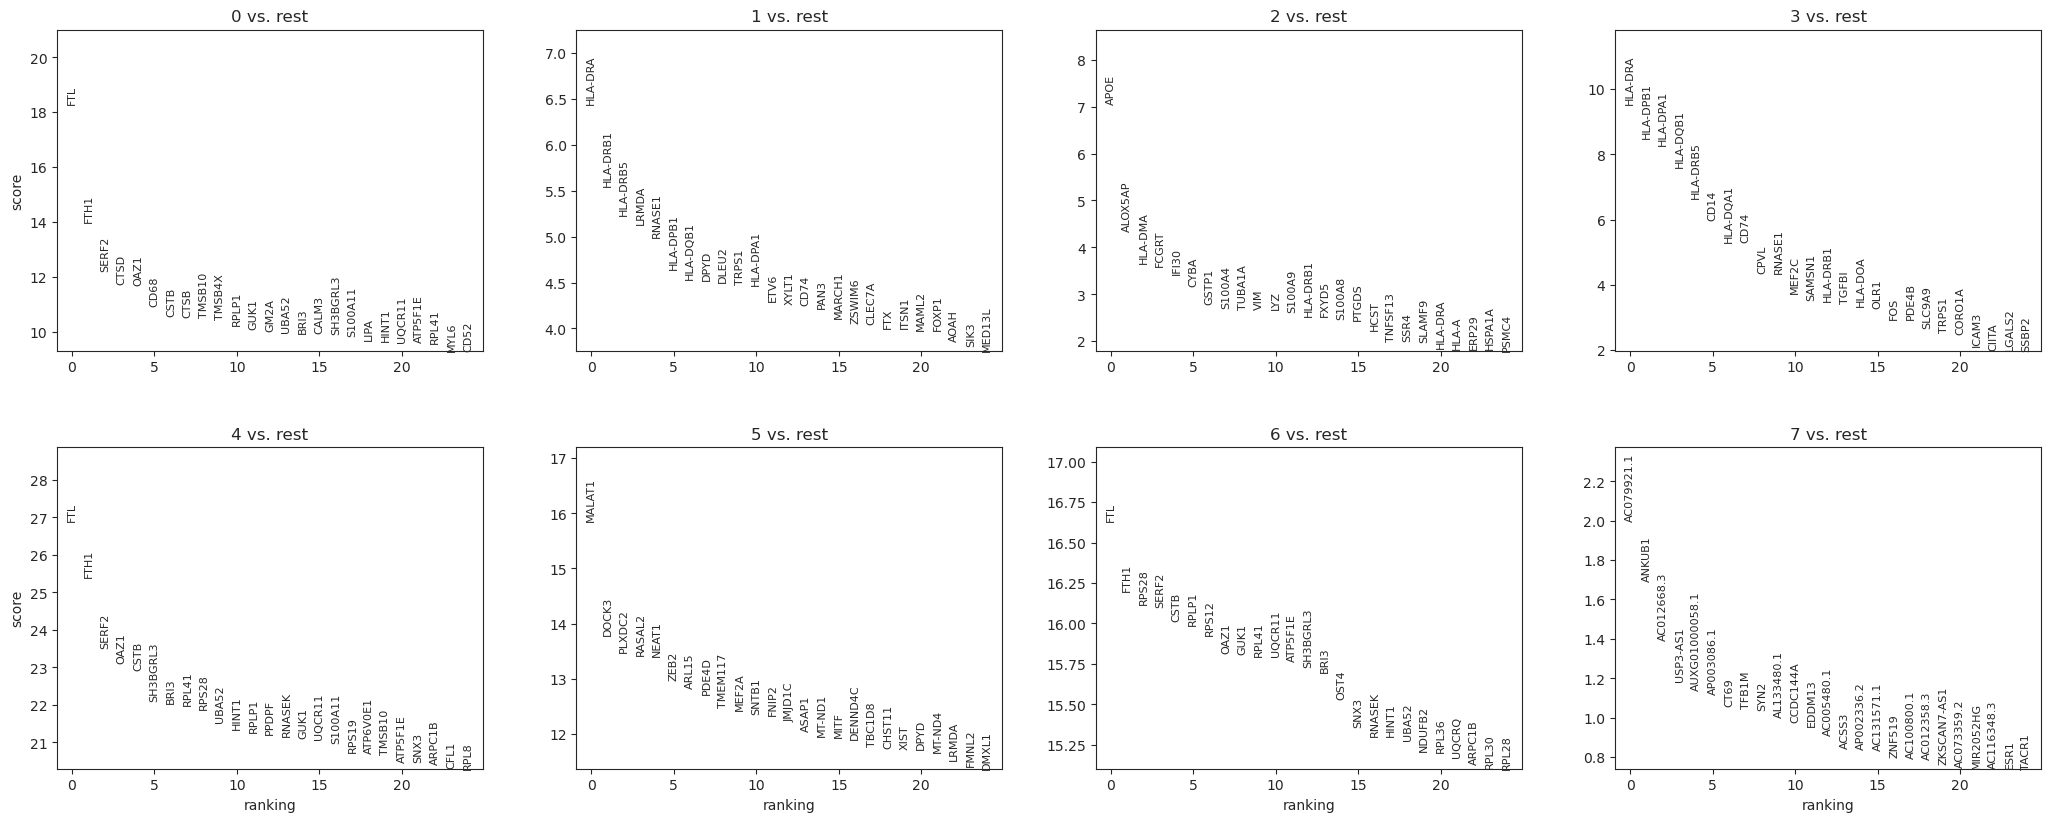

                  scores  logfoldchanges         pvals     pvals_adj
leiden names                                                        
0      FTL     18.307472             NaN  7.214170e-75  1.399188e-70
       FTH1    13.991362             inf  1.760086e-44  1.706844e-40
       SERF2   12.200363       11.405418  3.094423e-34  2.000545e-30
       CTSD    11.726974       22.554934  9.271521e-32  4.475778e-28
       OAZ1    11.708439        6.941380  1.153848e-31  4.475778e-28
...                  ...             ...           ...           ...
7      RPL41  -10.126473      -32.413307  4.215811e-24  5.744213e-21
       TMSB4X -10.128734     -166.774078  4.119496e-24  5.744213e-21
       RPL13  -10.131232      -29.651457  4.015576e-24  5.744213e-21
       FTH1   -10.170491     -870.551941  2.685511e-24  5.744213e-21
       FTL    -10.172276            -inf  2.636752e-24  5.744213e-21

[155160 rows x 4 columns]
                  scores  logfoldchanges         pvals     pvals_adj
leiden 

In [4]:
marks, figs_m = self.find_markers(n_genes=5, layer="scaled", 
                                  method="wilcoxon", key_reference="rest")
print(marks)
# marks.loc["6"].loc[marks.loc["6"].scores.abs().sort_values(ascending=False).iloc[:10].index]

## Inspect & Set Up Arguments for Later


This code looks more complicated than it actually would actually be for an end user because it was made to be generalizable across several datasets with particular column names, sizes that make it necessary to subset them in order to run the vignettes in a reasonable period of time, etc.

Basically, you won't need this code as an end user; this is just to choose relevant random subsets of genes, perturbations, etc. that are available in a given example dataset, for illustration purposes (and to conserve memory/time by not using every gene/condition/etc.). 

In real use cases, you will know what genes and conditions are of interest, and you can manually specify them by simply stating them in the appropriate arguments (such as `target_gene_idents`) or (in many cases) by not specifying the argument (resulting in the code using all available genes, etc.).

In [4]:
# Choose Subset of Sequenced Genes
genes = np.array((self.adata[assay] if assay else self.adata).var.reset_index(
    )[self._columns["col_gene_symbols"]].copy())
if file == "CRISPRi_scr":
    genes_subset = ["CDKN2A", "CDKN1A", "PLAUR", "TP53", "IL6ST", "IL1A", 
                    "CXCL8", "CCL2", "CEBPB", "NFKB1", "IGFBP7", "TGFB1", 
                    "BCL2", "PTGER4", "ERCC1", "ERCC4", "ATG16L1", "NOD2", "LACC1"]
else:
    genes_subset = list(pd.Series(genes).sample(10))

# Choose Subset of Target Genes
tga = (self.adata[assay] if assay else self.adata).obs[
    self._columns["col_target_genes"]][subset_mixscape].copy().unique()
# tga = list(pd.Series(tga)[pd.Series(tga).apply(
#     lambda t: sum((self.adata[assay].obs if assay else self.adata.obs)[
#         self._columns["col_target_genes"]] == t) > 3)])  # sufficient N
if file == "CRISPRi_scr":
    target_gene_idents = list(pd.Series(tga).dropna()[[
        ("ATG16L1" in x or "CDKN2A" in x or "PLAUR" in x 
         or "NOD2" in x or "PTGER4" in x or "IL6ST") and (
            len(x.split("|")) < 3) for x in pd.Series(tga).dropna()]])
    target_gene_idents = list(pd.Series(tga).dropna()[[
        ("ATG16L1" in x or "CDKN2A" in x or "PLAUR" in x 
         or "NOD2" in x or "PTGER4" in x or "IL6ST") and (
            len(x.split("|")) < 3) for x in pd.Series(tga).dropna()]])
else:
    target_gene_idents = list(pd.Series(tga).sample(3)) if len(tga) > 3 else True
print(f"\n\nGene Subset: {', '.join(list(genes_subset))}\n\n")
print(f"Targets: {target_gene_idents}")

# Perturbation Categories
(self.adata[assay] if assay else self.adata).obs[
    self._columns["col_perturbation"]]



Gene Subset: CDKN2A, CDKN1A, PLAUR, TP53, IL6ST, IL1A, CXCL8, CCL2, CEBPB, NFKB1, IGFBP7, TGFB1, BCL2, PTGER4, ERCC1, ERCC4, ATG16L1, NOD2, LACC1


Targets: ['NT', 'TMEM50B', 'NOD2', 'SNX17', 'RUNX3', 'RIPK2', 'INPP5D', 'SP110', 'PRDX6', 'HLA', 'DUSP1', 'IL10RB', 'IL6ST', 'RSBN1', 'ATG16L1', 'SNX20', 'WSB1', 'SP140L', 'CEBPB', 'PHTF1', 'STK11', 'GPX4', 'RASGRP1', 'PPARA', 'MAFB', 'PTPN22', 'KSR1', 'PAF1', 'PDPN', 'CRYZL1', 'LACC1', 'FASLG', 'POLR2E', 'IRF8', 'ZFP36', 'ABCA7', 'SP100', 'IFNAR2', 'RPN2', 'LGALS9', 'IFNGR2', 'TAGAP', 'SPHK2', 'HIPK1', 'CYLD', 'NRBP1', 'SBNO2', 'NR4A1', 'MYD88', 'CSF1R', 'PPM1G']


AAACCCAAGATTTGCC-1    KD
AAACCCAGTCTCAAGT-1    KD
AAACCCATCTCTCTTC-1    KD
AAACGAACAACTCCAA-1    NT
AAACGAAGTTGAAGTA-1    KD
                      ..
TTTGGAGAGTTGGGAC-1    KD
TTTGGAGTCCGCTAGG-1    NT
TTTGGAGTCCGGTTCT-1    KD
TTTGGTTGTCTTGAGT-1    KD
TTTGTTGAGGTGCAGT-1    KD
Name: name, Length: 2478, dtype: category
Categories (2, object): ['KD', 'NT']

## Basic Plots

In [ ]:
figs = self.plot(genes=genes_subset, layers="all", 
                 kws_gex_violin=dict(scale="area", figsize=(15, 15)))

# Perturbation Analyses

## Augur: Cell Type-Level Perturbation Response

Which cell types are most affected by perturbations? Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of experimental condition labels (e.g., treated versus untreated). The more separable the condition among cells of a given type, the higher the perturbation effect score.

<u> __Features__ </u>  

- Quantify and visualize degree of perturbation response by cell type

<u> __Input__ </u>  

<u> __Output__ </u>  

mean_augur_score

<u> __Notes__ </u>  

- col_perturbation + "_binary"
- Sub-sample sizes equal across conditions; does not account for perturbation-induced compositional shifts (cell type abundance)
- Scores are for cell types (aggregated across cells, not individual cells)
- Two modes
    - If select_variance_feature=True, run the original Augur implementation, which removes genes that don't vary much across cell type.
    - If False, use features selected by `scanpy.pp.highly_variable_genes()`, which is faster and sensitively recovers effects; however, the feature selection may yield inflated Augur scores because this reduced feature set is used in training, resulting in it taking advantage of the pre-existing power of this feature selection to separate cell types.
    - If False, you also have to be sure that "highly_variable_features" is a variable in your data. This can be complicated if you have a separate layer for perturbation data.

In [ ]:
augur_data, augur_results, figs_augur = self.run_augur(
    col_perturbation=self._columns["col_perturbation"], 
    key_treatment=self._keys["key_treatment"], 
    classifier="random_forest_classifier", n_threads=True,
    augur_mode="default", select_variance_features=True, n_folds=2,
    kws_umap=kws_umap, subsample_size=20, kws_augur_predict=dict(span=0.7))

## Mixscape: Cell-Level Perturbation Response

**Which cell types are most affected by perturbations?** Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of condition labels (e.g., treated versus untreated) and looking at how easy it is to tell perturbed versus non-perturbed (more separable = higher effect).

**Are there perturbation-specific clusters?** Mixscape uses linear discriminant analysis (LDA) to cluster cells that resemble each other in terms of gene expression and perturbation condition. _(LDA reduces dimensionality and attempts to maximize the separability of classes. Unperturbed cells are removed from analysis.)_

<u> __Features__ </u>  

- Remove confounds (e.g., cell cycle, batch effects)
- Classify cells as affected or unaffected (i.e., "escapees") by the perturbation
- Quantify and visualize degree of perturbation response

<u> __Input__ </u>  

<u> __Output__ </u>  
- Mixscape figures

<u> __Notes__ </u>  



Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': None, 'col_batch': None, 'key_nonperturbed': 'NP'}


Target gene SNX17 not in mixscape_class!


Target gene RASGRP1 not in mixscape_class!


Target gene ZFP36 not in mixscape_class!


Target gene SPI1 not in mixscape_class!


Target gene SP140L not in mixscape_class!


Target gene PRDX6 not in mixscape_class!


Target gene MYD88 not in mixscape_class!


Target gene IL10RB not in mixscape_class!


Target gene PDPN not in mixscape_class!


Target gene TMEM50B not in mixscape_class!


Target gene CRYZL1 not in mixscape_class!


Target gene HIPK1 not in mixscape_class!


Target gene INPP5D not in mixscape_class!


Target gene GPX4 not in mixscape_class!


Target gene IFNAR2 not in mixscape_class!


Target gene WSB1 not in mixscape_class!


Target gene RPN2 not in mixscape_class!


Target gene ABCA7 not in mixscape_class!


Target gene PPARA not in mixscape_class!


Target gene PPM1G

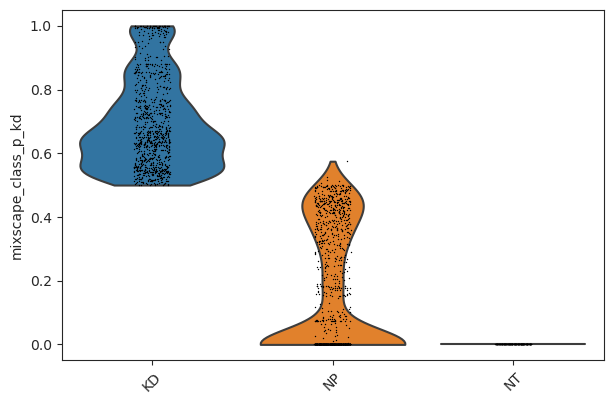

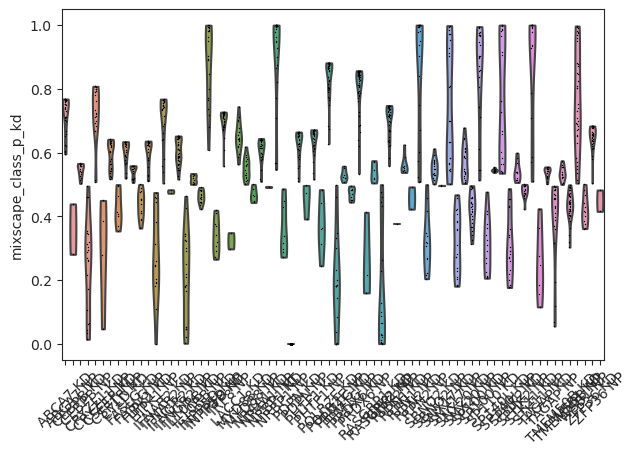

In [11]:
figs_mixscape = self.run_mixscape(col_split_by=col_split_by)

## Distance Metrics

See `self.figures[run_label]["distances"]` and  `self.results[run_label]["distances"]`
for results.

In [ ]:
fig_distance = self.compute_distance(
    subset=self.adata.obs[self._columns["col_target_genes"]].isin(
        [self._keys["key_control"], self._keys["key_nonperturbed"]
         ] + target_gene_idents),  # subset for quickness
    distance_type="edistance", method="X_pca")

## Composition Analysis

In [ ]:
out_ca = cr.ax.analyze_composition(
    self.adata, "1", assay=self._assay, analysis_type="cell_level", 
    generate_sample_level=False, **self._columns, sample_identifier=None, est_fdr=0.05)